# CCD spectrometer
* ## Background
* ## Calibration
* ## Laser
* ## Notch Filter 
* ## Detection probability of polarized light

Background is useless for the calibration measurements with Hg or white lamp. 

Errors are taken to be the statistical ones: $s_N = \frac{\sqrt{N}}{\sqrt{n}}$, where N is the number of counts and n the number of measurements that have been measured over.

The xlim for plotting is set globally.

In [1]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [2]:
import re
from scipy.constants import c,h,eV, pi
hceV = h * c  /eV
find_number = lambda string: re.search("-?\\d+",string).group(0)

from smooth import savitzky_golay
import uncertainties as uc
import uncertainties.unumpy as un

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)  # in inches; width corresponds to \textwidth in latex document (golden ratio)
        fig_dir = "../figures/"
        npy_dir = "./npy/"
        
xlim_global = (420, 620)

In [3]:
def breit_wigner(x, x0, gamma, amplitude, offset):
    """
    Breit-Wigner or Cauchy distribution with location parameter x0 
    and scale parameter gamma = 0.5 * FWHM. Amplitude: 1 / (Pi * gamma). 
    No mean, variance or higher moments exist.
    """
    return amplitude / ((pi*gamma) * (1 + ((x - x0) / gamma)**2)) + offset
   
def bw_fit(x, y, y_e, x_range, p0, fit=True):
    x_min, x_max = x_range
    mask = (x > x_min) * (x < x_max)
    x_fit = x[mask]
    y_fit = y[mask]
    y_sigma = np.sqrt(un.std_devs(y_e[mask]))
    
    if fit:
        coeff, cov = curve_fit(breit_wigner, x_fit, y_fit, p0=p0, 
                                  sigma=y_sigma, absolute_sigma=True)
        c = uc.correlated_values(coeff, cov)
        fit_peak = breit_wigner(x_fit, *coeff)
    else:
        fit_peak = breit_wigner(x_fit, *p0)
        c = p0
    
    return x_fit, fit_peak, c

In [4]:
def print_c(c):
    """
    input format: uc.ufloat
    rounds float and corrisponding error to last significant digit
    returns float and error as string
    as integers with max 4 error digits
    as floats with max 3 error digits
    as exp else
    """
    digit = -int(np.floor(np.log10(c.s)))    
    if (c.s * 10**digit) < 1.5: # convention...
        digit += 1
    c_r = round(c.n, digit)
    s_c_r = round(c.s, digit)
    if (-3 < digit) * (digit <= 0): # returns readable integers
        c_str = '%i \pm %i'%(c_r, s_c_r)
    elif (0 < digit) * (digit < 4): # returns readable floats (max 3 digits)
        c_str = ('%.' + str(digit) + 'f \pm %.' + str(digit) + 'f')%(c_r, s_c_r)
    else: # returns exp
        c_str = ('(%.1f \pm %.1f)\mathrm{e}%i')%(c_r * 10**(digit-1), s_c_r * 10**(digit-1), -(digit-1))
    return c_str

## Background

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


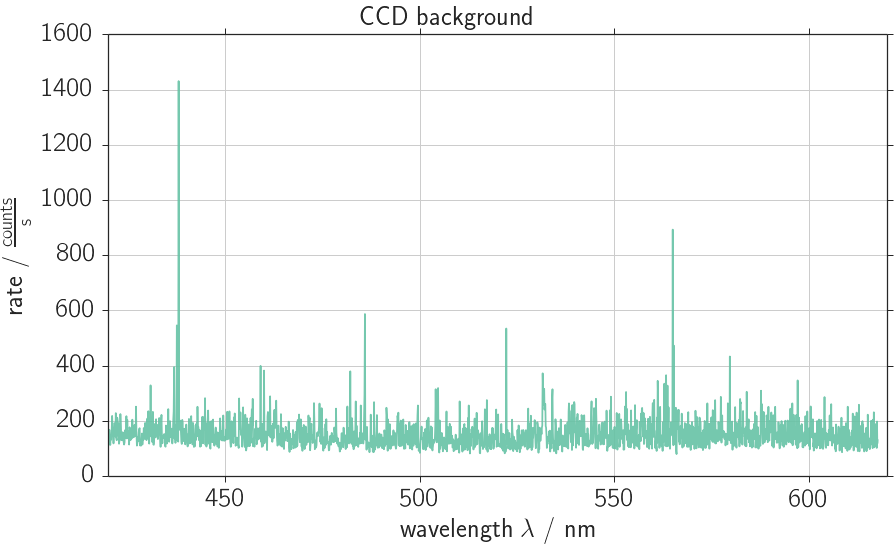

In [5]:
#### Background ####
filename = "ccd_bg_30_10"

# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))

rate_bg = y / t
rate_bg_e = y_e / t

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD background')
ax.plot(x, rate_bg, "-", alpha = 0.9)
ax.set_xlim(xlim_global)
ax.set_xlabel('wavelength $\lambda$ / nm')
ax.set_ylabel('rate / $\mathrm{\\frac{counts}{s}}$')
ax.grid(True)
#ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_background"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Calibration

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


0.005


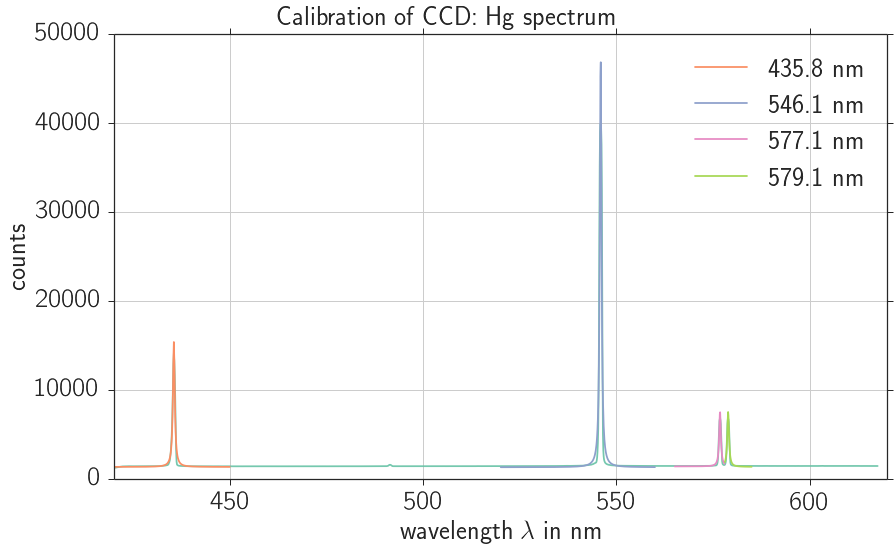

In [6]:
filename = "ccd_hg_00"
# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from
print(t)

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))

# Fitting
# p = [x0, gamma, amplitude, offset]
###### PEAK 1 #################
# Define range to be fitted
x_range = [420, 450]   # lower and upper bound
p0 = np.array([435, 0.2, 14000, 0])
x_fit1, fit_peak1, c1 = bw_fit(x, y, y_e, x_range, p0, fit=True)

###### PEAK 2 #################
# Define range to be fitted
x_range = [520, 560]   # lower and upper bound
p0 = np.array([545, 0.2, 40000, 0])
x_fit2, fit_peak2, c2 = bw_fit(x, y, y_e, x_range, p0, fit=True)

###### PEAK 3 #################
# Define range to be fitted
x_range = [565, 578]   # lower and upper bound
p0 = np.array([577, 0.2, 5000, 0])
x_fit3, fit_peak3, c3 = bw_fit(x, y, y_e, x_range, p0, fit=True)

###### PEAK 4 #################
# Define range to be fitted
x_range = [578, 585]   # lower and upper bound
p0 = np.array([579, 0.2, 5000, 0])
x_fit4, fit_peak4, c4 = bw_fit(x, y, y_e, x_range, p0, fit=True)


# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Calibration of CCD: Hg spectrum')
ax.plot(x, y, "-", alpha = 0.9)
ax.plot(x_fit1, fit_peak1, "-", label='435.8 nm')
ax.plot(x_fit2, fit_peak2, "-", label='546.1 nm')
ax.plot(x_fit3, fit_peak3, "-", label='577.1 nm')
ax.plot(x_fit4, fit_peak4, "-", label='579.1 nm')
ax.set_xlim(xlim_global)
#ax.set_ylim(0,10000)
ax.set_xlabel("wavelength $\lambda$ in nm")
ax.set_ylabel('counts')
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_calibration_hg"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

### Calibration: Linear fit

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


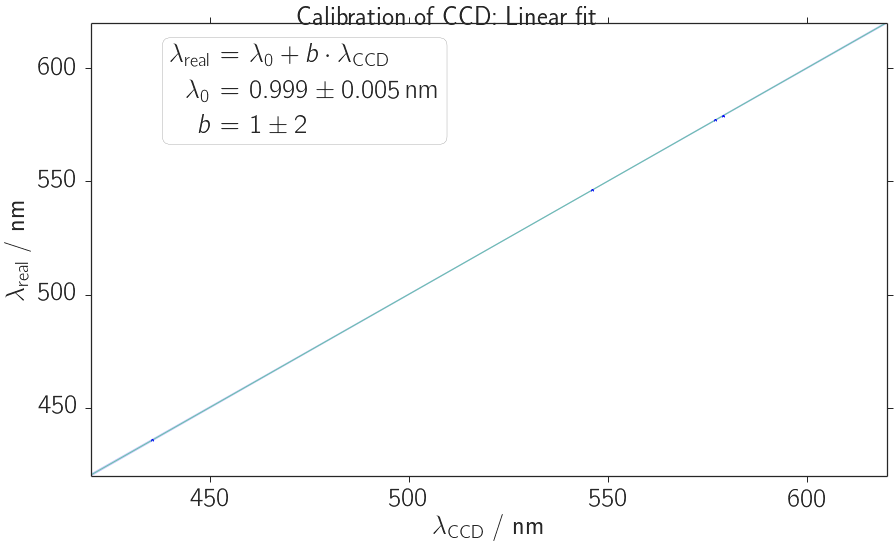

In [7]:
# Get all peaks. Use HWHM = gamma as error on peaks.
cs = [c1, c2, c3, c4]
x0 = un.nominal_values([c[0] for c in cs])
s_x0 = un.nominal_values([c[1] for c in cs])
x0_e = un.uarray(x0, s_x0)

lit_peaks = np.array([435.8, 546.1, 577.1, 579.1])

def linear(x, a, b):
    return (a*x + b)
coeff_lin, cov_lin = curve_fit(linear, lit_peaks, x0, p0=None, 
                               sigma=np.sqrt(s_x0), absolute_sigma=True)
c_lin = uc.correlated_values(coeff_lin, cov_lin)
# Switch to lambda(x0) = lit_peak(x0)
d_lin = np.array([1 / c_lin[0], -c_lin[1] / c_lin[0]])
np.save(npy_dir + 'ccd_calibration', d_lin)

# Plotting
colors = ['b', 'g', 'r', 'pink']
x_min, x_max = [420, 650]
x = np.linspace(x_min, x_max, 200)
fit = linear(x, *d_lin)

fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle('Calibration of CCD: Linear fit')
ax1.fill_between(x, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)
ax1.plot(x, un.nominal_values(fit), '-', linewidth=1.0)  
ax1.errorbar(x0, lit_peaks, xerr=s_x0, yerr=None, fmt='b,', elinewidth=1.0, capsize=1.2, capthick=0.8)
ax1.set_xlim(xlim_global)
ax1.set_ylim(xlim_global)
ax1.set_xlabel("$\lambda_\mathrm{CCD}$ / nm")
ax1.set_ylabel("$\lambda_\mathrm{real}$ / nm")
#ax1.legend(loc=1)

# Get the parameters ofthe linear fit to be presented in a textbox
l0_str = print_c(d_lin[0])
b_str = print_c(d_lin[1])
textstr = "\\begin{eqnarray*} \
        \\ \lambda_\mathrm{real} &=& \lambda_0 + b \cdot \lambda_\mathrm{CCD} \\\\ \
        \\ \lambda_0 &=& %s \,\mathrm{nm} \\\\ \
        \\ b &=& %s\
        \end{eqnarray*}"%(l0_str,b_str)
ax1 = plt.gca()
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)

if show_fig:
    fig1.show()
if save_fig:
    file_name = "ccd_calibration_linear_fit"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

Apparently the CCD is calibrated just right. In the following procedure, we don't transform measured wavelength to 'real' ones but add an error of $s_\lambda = 0.5$ nm to the wavelength (see below).

In [8]:
print(linear(450, *d_lin))
print(linear(500, *d_lin))
print(linear(600, *d_lin))

450.3+/-0.5
500.28+/-0.31
600.2+/-0.4


## Analysing the laser

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


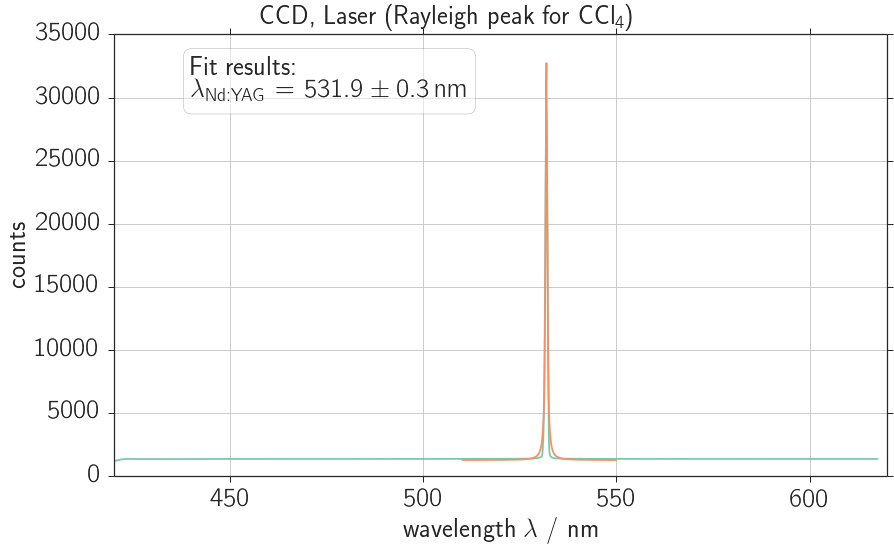

In [9]:
filename = "ccd_laser_ccl4_00"
# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))

# Fitting
# p = [x0, gamma, amplitude, offset]
###### PEAK 1 #################
# Define range to be fitted
x_range = [510, 550]   # lower and upper bound
p0 = np.array([531, 0.4, 27000, 1420])
x_fit1, fit_peak1, c1 = bw_fit(x, y, y_e, x_range, p0, fit=True)


# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD, Laser (Rayleigh peak for CCl$_4$)')
ax.plot(x, y, "-", alpha = 0.9)
ax.plot(x_fit1, fit_peak1, "-", label='Nd:YAG paek at 532 nm')
ax.set_xlim(xlim_global)
#ax.set_xlim(565, 585)
#ax.set_ylim(0,10000)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
#ax.legend(loc='best')

# Get the parameters ofthe linear fit to be presented in a textbox
peak_str = print_c(uc.ufloat(c1[0].n, c1[1].n))
textstr = "Fit results:\n \
        \\begin{eqnarray*} \
        \\ \lambda_\mathrm{Nd:YAG} &=& %s \,\mathrm{nm} \\\\ \
        \end{eqnarray*}"%(peak_str)
ax1 = plt.gca()
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)

if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_laser_peak"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Notch filter

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


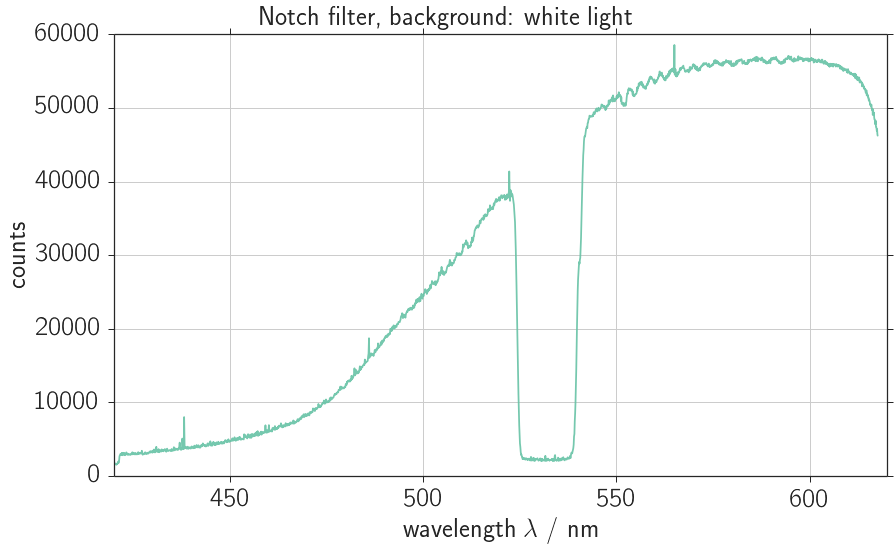

In [10]:
filename = "ccd_white_notch"
# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y = np.load("npy/"+filename+"_count.npy")
y_e = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('Notch filter, background: white light')
ax.plot(x, y, "-", alpha = 0.9)
ax.set_xlim(xlim_global)
#ax.set_xlim(565, 585)
#ax.set_ylim(0,10000)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
#ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_notch_filter"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

## Detection probability of polarized light

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


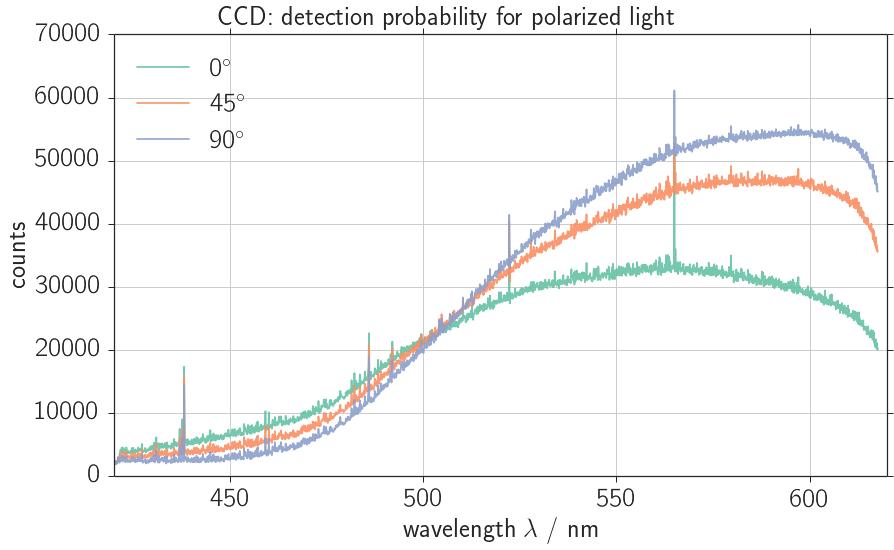

In [11]:
filename = "ccd_white_pol0"
# Get integration time and number of measurements
f = open("data/" + filename + ".txt", encoding='cp1252')
lines = f.readlines()
f.close()
t = np.float(lines[8].split(' ')[2]) * 1e-6 # measured time in sec
avg = np.float(lines[9].split(' ')[3]) # number of recording to take average from

# Data
x = np.load("npy/"+filename+"_lamb.npy")
y0 = np.load("npy/"+filename+"_count.npy")
y_e0 = un.uarray(y, np.maximum(1, np.sqrt(y / avg)))
filename = "ccd_white_pol45"
y45 = np.load("npy/"+filename+"_count.npy")
y_e45 = un.uarray(y45, np.maximum(1, np.sqrt(y45 / avg)))
filename = "ccd_white_pol90"
y90 = np.load("npy/"+filename+"_count.npy")
y_e90 = un.uarray(y90, np.maximum(1, np.sqrt(y90 / avg)))

# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: detection probability for polarized light')
ax.plot(x, y0, "-", alpha = 0.9, label='$0^\circ$')
ax.plot(x, y45, "-", alpha = 0.9, label='$45^\circ$')
ax.plot(x, y90, "-", alpha = 0.9, label='$90^\circ$')
ax.set_xlim(xlim_global)
#ax.set_xlim(565, 585)
#ax.set_ylim(0,10000)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("counts")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_polarized"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")

### Subtracting measurements for $0^\circ$ and $90^\circ$ from that at $45^\circ$ and divide the difference by the actual intensity in order to get corrections. This neglects nonlinear effects...

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


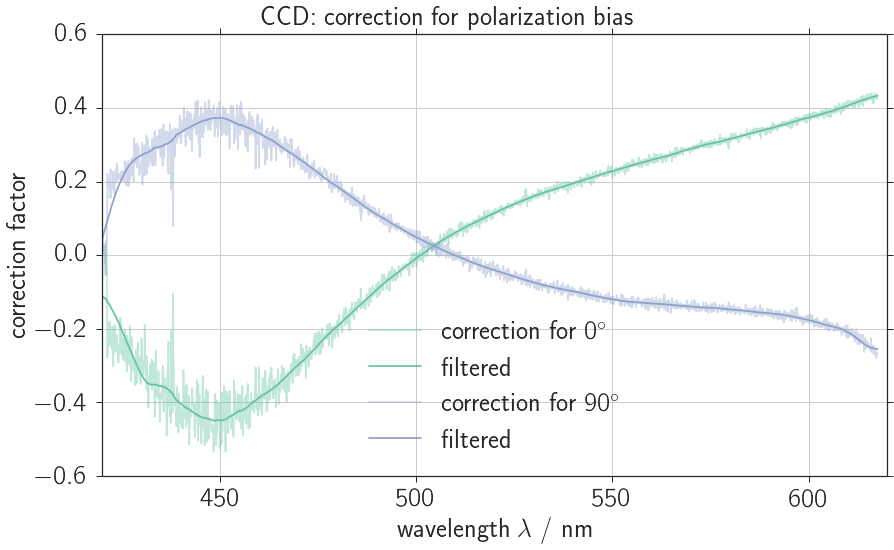

In [12]:
n_sav = 301
corr0  = (y45 - y0) / y45
corr90 = (y45 - y90) / y45
# filter
corr0_fil = savitzky_golay(corr0, n_sav, 4)
corr90_fil = savitzky_golay(corr90, n_sav, 4)


# remove outlier!
mstep = np.argmin(corr0[1:] - corr0[:-1]) + 1 # find the outlier
n = 20
low = corr0[mstep - n: mstep]
up = corr0[mstep + 1: mstep + n + 1]
corr_avg = np.mean(low + up) / 2 
corr0[mstep] = corr_avg # replace it by the mean of the n values in both directions
corr_rep = savitzky_golay(corr0, n_sav, 4)
corr0_fil = corr_rep


# Plotting
fig, ax = plt.subplots(1,1)
if not save_fig:
    fig.suptitle('CCD: correction for polarization bias')
plot0,  = ax.plot(x, corr0,  "-", alpha = 0.4, label='correction for $0^\circ$')
ax.plot(x, corr0_fil,  "-", alpha = 0.99, c=plot0.get_color(), label='filtered')
plot90, = ax.plot(x, corr90, "-", alpha = 0.4, label='correction for $90^\circ$')
ax.plot(x, corr90_fil, "-", alpha = 0.99, c=plot90.get_color(), label='filtered')
#ax.plot(x, corr0_fil - corr_rep, "-", alpha = 0.99, c=plot90.get_color(), label='filtered')
ax.set_xlim(xlim_global)
#ax.set_xlim(540, 590)
#ax.set_ylim(0,10000)
ax.set_xlabel("wavelength $\lambda$ / nm")
ax.set_ylabel("correction factor")
ax.grid(True)
ax.legend(loc='best')
if show_fig:
    fig.show()
if save_fig:
    file_name = "ccd_correction"
    fig.savefig(fig_dir + file_name + ".pdf")
    fig.savefig(fig_dir + file_name + ".png")